*   **依序執行以下兩個cell，執行後會出現以下畫面，直接輸入搜尋詞即可**
*   **第一次執行會等比較久! (約 5 分鐘)**
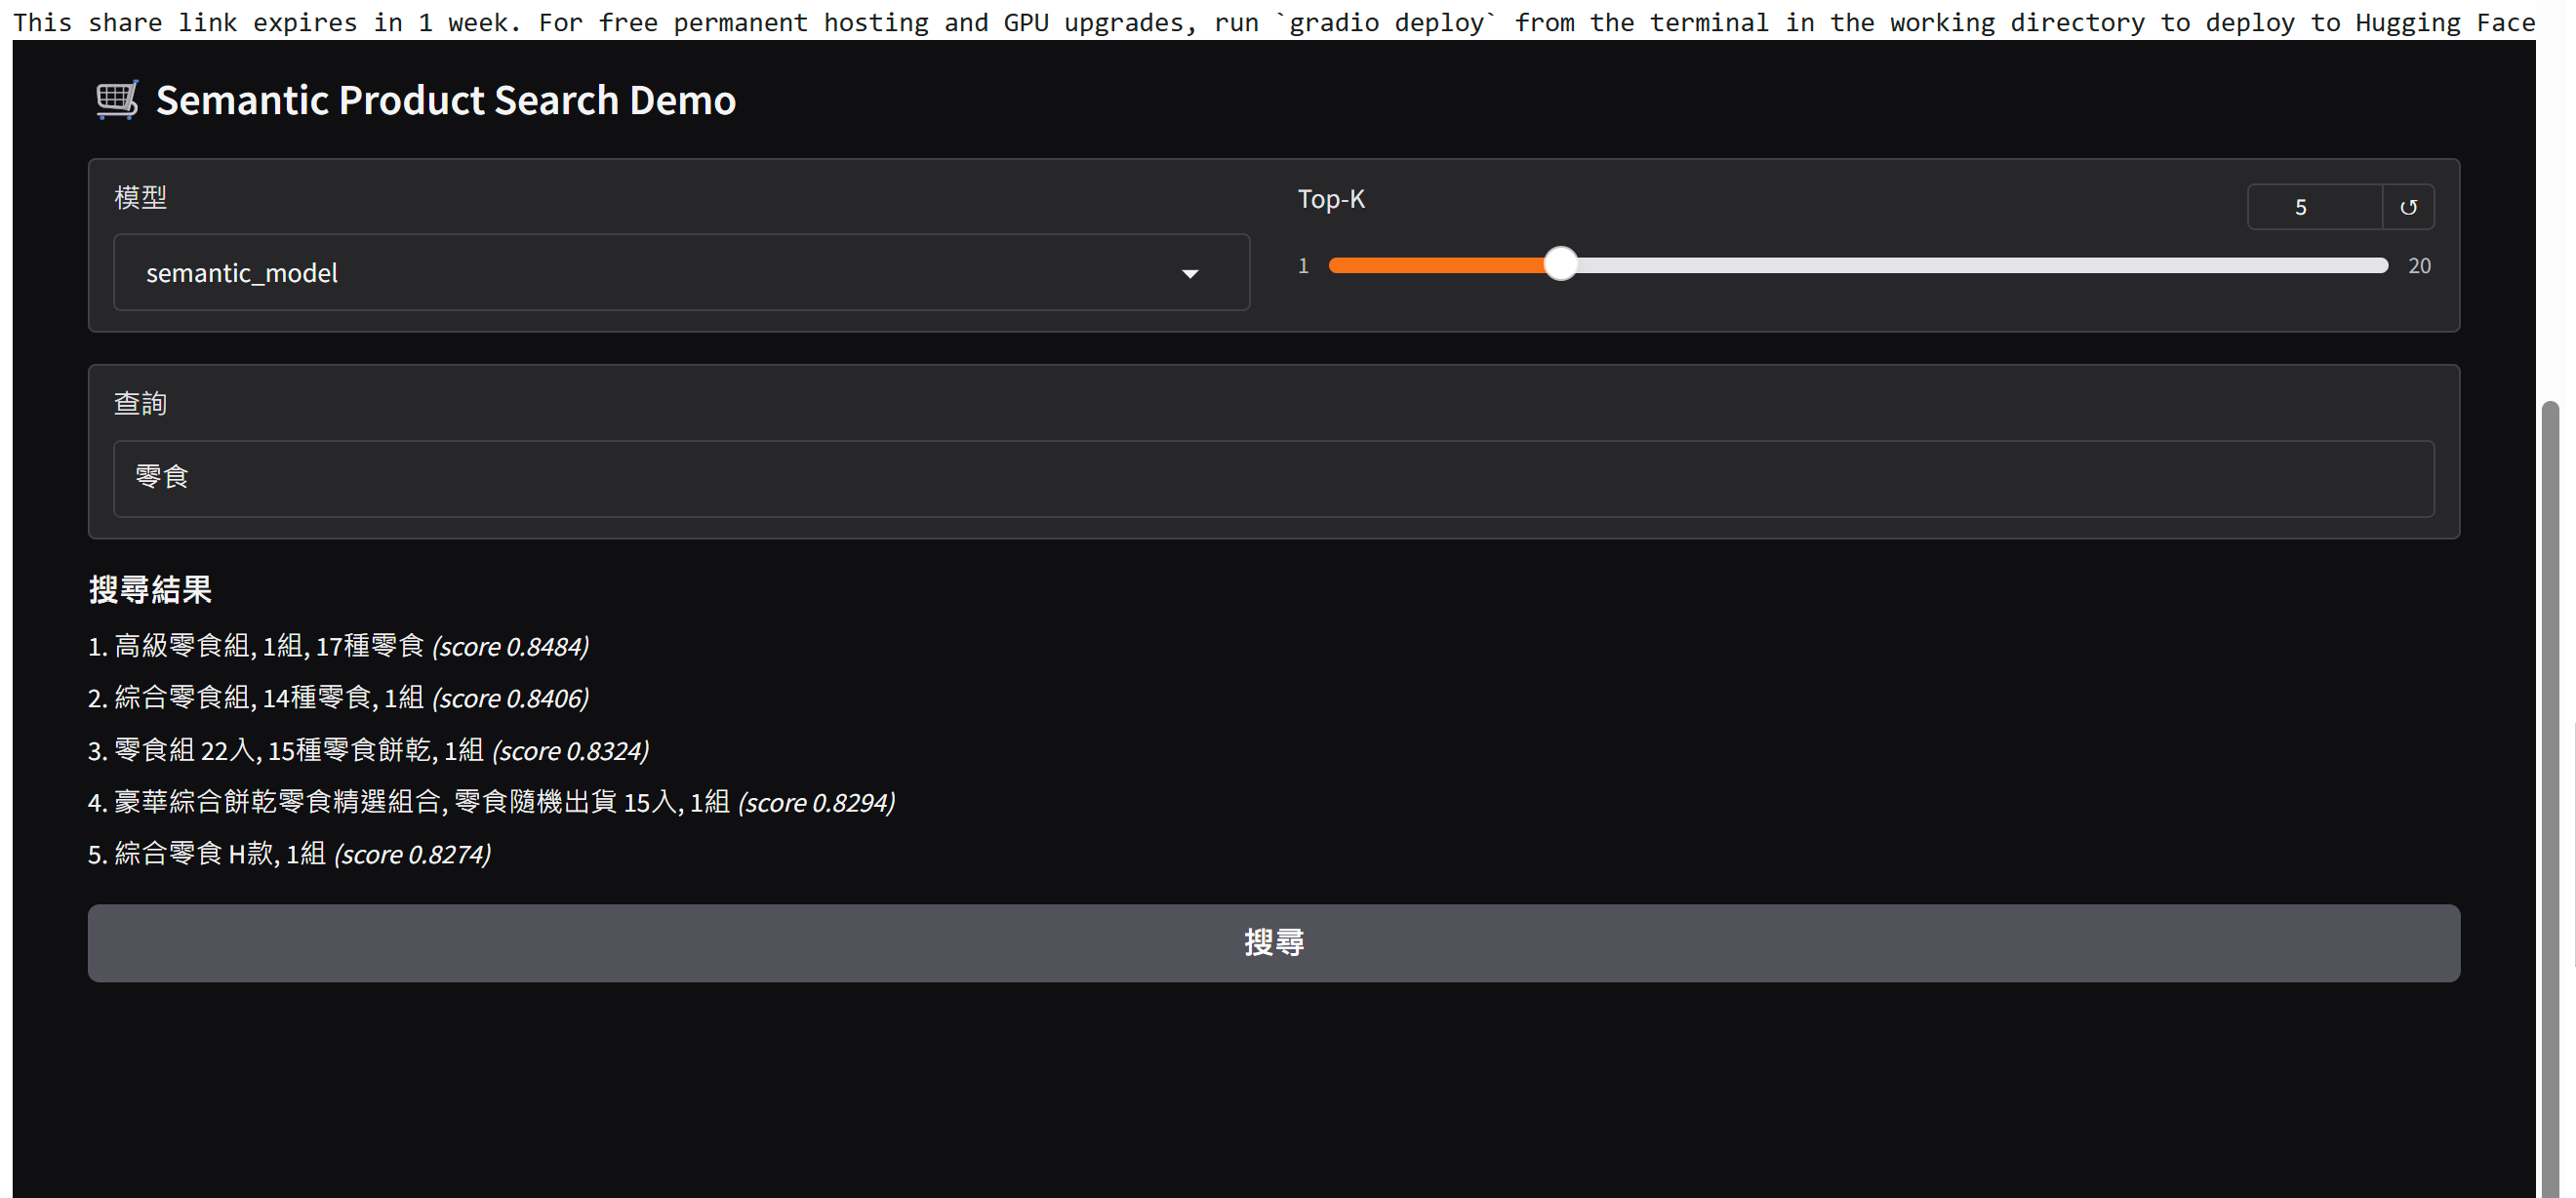

In [1]:
!git clone https://github.com/agbld/semantic-search-for-EE5327701.git
%cd semantic-search-for-EE5327701
!pip install -r requirements.txt -qq
!pip install gradio -qq

Cloning into 'semantic-search-for-EE5327701'...
remote: Enumerating objects: 108, done.
remote: Counting objects: 100% (66/66), done.
remote: Compressing objects: 100% (45/45), done.
remote: Total 108 (delta 34), reused 50 (delta 21), pack-reused 42 (from 1)
Receiving objects: 100% (108/108), 135.20 KiB | 3.14 MiB/s, done.
Resolving deltas: 100% (57/57), done.
/content/semantic-search-for-EE5327701
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 22.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 429.3/429.3 kB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.3/31.3 MB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 60.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 63.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import os, time, numpy as np, pandas as pd, faiss, gradio as gr
import get_dataset

os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

_CACHE = {}

def _load_resources(model_type: str):
    if model_type in _CACHE:
        return _CACHE[model_type]

    if model_type == "semantic_model":
        from semantic_model import get_semantic_model, inference
        model, tokenizer = get_semantic_model()
    elif model_type == "ckipbert":
        from ckipbert import get_ckipbert, inference
        model, tokenizer = get_ckipbert()
    else:
        raise ValueError(f"Unknown model_type: {model_type}")

    embeds_dir = f"./embeddings/{model_type}"
    if not os.path.isdir(embeds_dir):
        raise FileNotFoundError(f"{embeds_dir} 不存在，請確認資料集是否成功下載")

    names, embeds = [], []
    for fname in os.listdir(embeds_dir):
        if fname.endswith(".npy"):
            embeds.append(np.load(os.path.join(embeds_dir, fname)))
            csv = fname.replace(".npy", ".csv")
            names.extend(pd.read_csv(f"./random_samples_1M/{csv}")["product_name"])

    embeds = np.concatenate(embeds).astype("float32")
    faiss.normalize_L2(embeds)
    index = faiss.IndexFlatIP(embeds.shape[1]); index.add(embeds)

    _CACHE[model_type] = {
        "model": model,
        "tokenizer": tokenizer,
        "inference": inference,
        "names": pd.Series(names),
        "index": index,
    }
    return _CACHE[model_type]

def search(query: str, model_type: str, top_k: int):
    if not query.strip():
        return "⚠️ 請輸入查詢關鍵字"
    res = _load_resources(model_type)
    q_emb, _ = res["inference"](res["tokenizer"], res["model"], [query], 16)
    faiss.normalize_L2(q_emb)
    scores, idx = res["index"].search(q_emb.astype("float32"), top_k)
    hits = [
        f"{i+1:>2}. {res['names'].iloc[j]}  _(score {scores[0][i]:.4f})_"
        for i, j in enumerate(idx[0])
    ]
    return "### 搜尋結果\n" + "\n".join(hits)

with gr.Blocks() as demo:
    gr.Markdown("## 🛒 Semantic Product Search Demo")
    with gr.Row():
        model_dd = gr.Dropdown(["semantic_model", "ckipbert"], value="semantic_model", label="模型")
        topk = gr.Slider(1, 20, value=5, step=1, label="Top-K")
    query_box = gr.Textbox(label="查詢")
    out_md = gr.Markdown()
    gr.Button("搜尋").click(search, [query_box, model_dd, topk], out_md)

if __name__ == "__main__":
    for m in ["semantic_model", "ckipbert"]:
        try:
            _load_resources(m)
            print(f"[warm-up] {m} loaded ✔")
        except Exception as e:
            print(f"[warm-up] {m} skipped → {e}")

    demo.queue(
        default_concurrency_limit=1,
        max_size=12
    ).launch(
        share=True,
        debug=True,
        height=1000,
        max_threads=40,
    )


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


semantic_model.zip:   0%|          | 0.00/1.41G [00:00<?, ?B/s]

ckipbert.zip:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

random_samples_1M.zip:   0%|          | 0.00/30.9M [00:00<?, ?B/s]

Unzipped /root/.cache/huggingface/hub/datasets--clw8998--Semantic-Search-dataset-for-EE5327701/snapshots/e3ca334e0b55ab2473a0f802e8db1349d7400e8f/semantic_model.zip to current directory.
Deleted zip file: /root/.cache/huggingface/hub/datasets--clw8998--Semantic-Search-dataset-for-EE5327701/snapshots/e3ca334e0b55ab2473a0f802e8db1349d7400e8f/semantic_model.zip
Created embeddings folder at /content/semantic-search-for-EE5327701/embeddings
Moved ./semantic_model to /content/semantic-search-for-EE5327701/embeddings/semantic_model
Unzipped /root/.cache/huggingface/hub/datasets--clw8998--Semantic-Search-dataset-for-EE5327701/snapshots/e3ca334e0b55ab2473a0f802e8db1349d7400e8f/ckipbert.zip to current directory.
Deleted zip file: /root/.cache/huggingface/hub/datasets--clw8998--Semantic-Search-dataset-for-EE5327701/snapshots/e3ca334e0b55ab2473a0f802e8db1349d7400e8f/ckipbert.zip
Moved ./ckipbert to /content/semantic-search-for-EE5327701/embeddings/ckipbert
Unzipped /root/.cache/huggingface/hub/dat

config.json:   0%|          | 0.00/903 [00:00<?, ?B/s]

model.onnx:   0%|          | 0.00/30.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.43k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/110k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/439k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/695 [00:00<?, ?B/s]

[warm-up] semantic_model loaded ✔


tokenizer_config.json:   0%|          | 0.00/174 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/110k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/701 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/409M [00:00<?, ?B/s]

Some weights of BertModel were not initialized from the model checkpoint at ckiplab/bert-base-chinese and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/409M [00:00<?, ?B/s]

[warm-up] ckipbert loaded ✔
Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://2a58ed7e0be0c1a986.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
